# Transfer Learning with Tensorflow Part 3: Scaling up

We've seen the power of transfer learning featuter extraction and fine-tuning, now its time to scale up to all of the classes in Food101. (101 total classes of food)

Our goal is to beat the original Food101 paper.

Baseline: 50.67%

In [1]:
import tensorflow as tf
gpu = tf.config.list_physical_devices('GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating helper functions

In previous notebooks we've created series of helper functions but it is difficult to do that every single time so let's download them

In [2]:
def download_helper_functions():
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
#Download the helper function
import os
path = os.getcwd()
if not os.path.exists('/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Transfer Learning/helper_functions.py'):
    download_helper_functions()

--2024-02-23 06:48:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-23 06:48:04 (120 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, make_confusion_matrix

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data

The data we're downlaoding comes from the original Food101 but was preprocessed

In [5]:
if not os.path.exists('/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Transfer Learning/101_food_classes_10_percent.zip'):
    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
    unzip_data('101_food_classes_10_percent.zip')

--2024-02-23 06:48:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 173.194.79.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  29.0MB/s    in 58s     

2024-02-23 06:49:04 (26.6 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
TRAIN_DIR = '101_food_classes_10_percent/train/'
TEST_DIR = '101_food_classes_10_percent/test/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'

In [7]:
# How many images classes are there
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/samosa'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classe

In [8]:
# Setup data inputs
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR, label_mode= LABEL_MODE, image_size= IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, label_mode= LABEL_MODE, image_size= IMG_SIZE, shuffle= False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Steps we're going to take:
* Create a ModelCcheckpoint callback
* Create a data augmnetation layer to build data augmentation right into the model
* Build a headless Functional EfficientNetB0 backbone-model
* Comple our model
* Feature extract for 5 full passes (15% of test dataset which will be the validation dataset   )

In [9]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only= True, monitor= "val_accuracy", save_best_only= True)

In [10]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    # preprocessing.Rescalinig(1/255.) required onlu if the data scaling is not present in the model
], name= 'data_augmentation_layer')

In [11]:
# Setup the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False)
base_model.trainable = False

# Setup model archtecture with trainable top layers
inputs = layers.Input(shape= IMG_SIZE + (3, ), name= "input_layer")
x = data_augmentation(inputs)
x = base_model(x, training= False) # put the base model n inference mode so the weights which need to stay frozen stay as it is
x = layers.GlobalAveragePooling2D(name= "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation= "softmax", name= "output_layer")(x)

model = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 1s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [13]:
# Compiilng the model
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.legacy.Adam(),
              metrics= ['accuracy'])

In [14]:
with tf.device('/device:GPU:0'):
    history_10_percent = model.fit(train_data,
                                epochs= 5,
                                steps_per_epoch= len(train_data),
                                validation_data= test_data,
                                validation_steps= int(0.15 * len(test_data)))

Epoch 1/5
237/237 [==============================] - 72s 263ms/step - loss: 3.3742 - accuracy: 0.2752 - val_loss: 2.4688 - val_accuracy: 0.4640
Epoch 2/5
237/237 [==============================] - 42s 177ms/step - loss: 2.1975 - accuracy: 0.5051 - val_loss: 2.0017 - val_accuracy: 0.5241
Epoch 3/5
237/237 [==============================] - 37s 156ms/step - loss: 1.8212 - accuracy: 0.5659 - val_loss: 1.8619 - val_accuracy: 0.5347
Epoch 4/5
237/237 [==============================] - 31s 132ms/step - loss: 1.6191 - accuracy: 0.6116 - val_loss: 1.7947 - val_accuracy: 0.5355
Epoch 5/5
237/237 [==============================] - 29s 123ms/step - loss: 1.4403 - accuracy: 0.6494 - val_loss: 1.7188 - val_accuracy: 0.5546


In [15]:
model.evaluate(test_data)

790/790 [==============================] - 23s 28ms/step - loss: 1.5919 - accuracy: 0.5804


[1.5919225215911865, 0.5803960561752319]

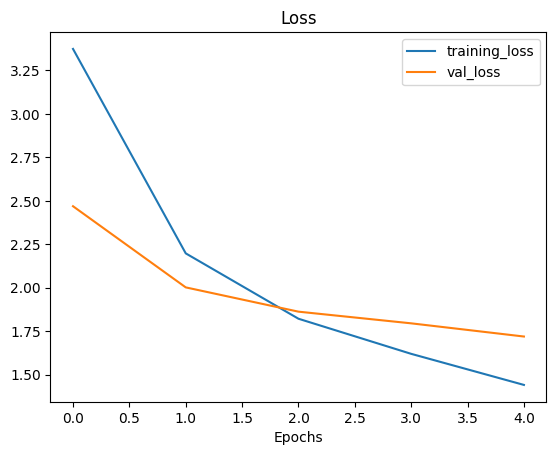

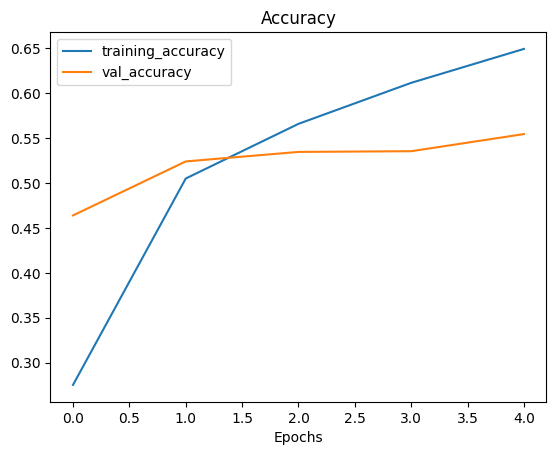

In [16]:
plot_loss_curves(history_10_percent)

> Accordinig to the history, the model is not learning in the correct manner so we need to fine-tune the model. The model is over-fitting

## Fine-tuning

In [17]:
# Unfreeze all of the layers iin the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable= False

In [18]:
# Recompile the model using lower learning rate
model.compile(loss= 'categorical_crossentropy',
              optimizer= tf.keras.optimizers.legacy.Adam(learning_rate= 0.0001),
              metrics= ['accuracy'])

In [19]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
for i, layer in enumerate(model.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [21]:
fine_tune_epochs = 10

In [22]:
tf.random.set_seed(42)
tf.config.set_soft_device_placement(True)
with tf.device('/device:GPU:0'):
    history_10_percent_fine_tune = model.fit(train_data,
            epochs= fine_tune_epochs,
            validation_data= test_data,
            validation_steps= int(0.15 * len(test_data)),
            initial_epoch= 5)

Epoch 6/10
237/237 [==============================] - 36s 124ms/step - loss: 1.2144 - accuracy: 0.6853 - val_loss: 1.6349 - val_accuracy: 0.5704
Epoch 7/10
237/237 [==============================] - 26s 110ms/step - loss: 1.0996 - accuracy: 0.7077 - val_loss: 1.6779 - val_accuracy: 0.5569
Epoch 8/10
237/237 [==============================] - 25s 104ms/step - loss: 1.0217 - accuracy: 0.7213 - val_loss: 1.6271 - val_accuracy: 0.5715
Epoch 9/10
237/237 [==============================] - 24s 102ms/step - loss: 0.9448 - accuracy: 0.7424 - val_loss: 1.5947 - val_accuracy: 0.5813
Epoch 10/10
237/237 [==============================] - 23s 95ms/step - loss: 0.8864 - accuracy: 0.7580 - val_loss: 1.6764 - val_accuracy: 0.5630


In [23]:
model.evaluate(test_data)

790/790 [==============================] - 22s 28ms/step - loss: 1.5239 - accuracy: 0.5979


[1.5238860845565796, 0.5979009866714478]

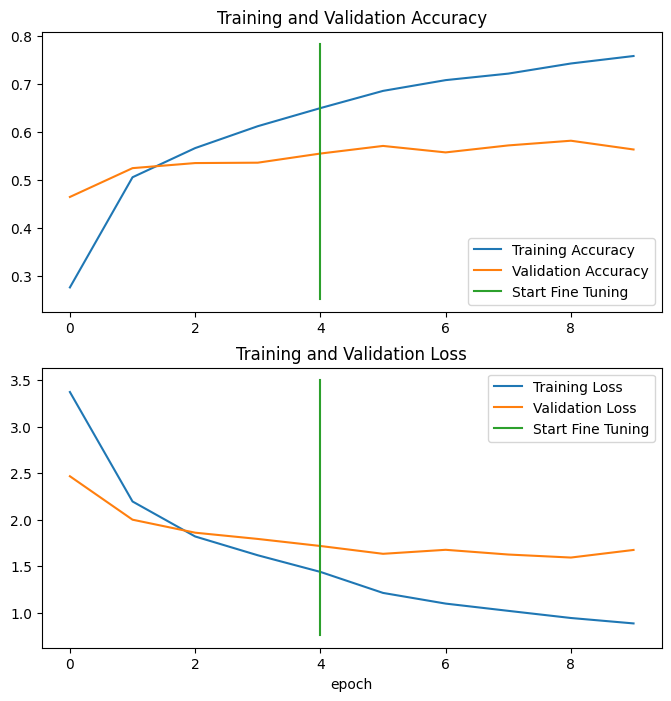

In [24]:
compare_historys(original_history= history_10_percent,
                 new_history= history_10_percent_fine_tune)

## Save and load our model

To use our model in external application, we'll need to save it and export it somwewhere

In [25]:
# Save our model
model.save("model/101_food_classes_10_percent_all_data")

In [26]:
# Load model
load_model = tf.keras.models.load_model("model/101_food_classes_10_percent_all_data")

In [27]:
# Evaluate loaded model and compare performance to pre saved model
loaded_result = load_model.evaluate(test_data)
loaded_result

790/790 [==============================] - 26s 31ms/step - loss: 1.5239 - accuracy: 0.5979


[1.5238860845565796, 0.5979009866714478]

In [28]:
all_classes_fine_tune_result = model.evaluate(test_data)

790/790 [==============================] - 22s 28ms/step - loss: 1.5239 - accuracy: 0.5979


## Evaluating performance of the model across all different classes

Let's make some prediction, visulize and then later find out which predictions were whic predictions wer the most wrong

In [29]:
# Downloading pre trained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-02-23 06:57:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.207, 108.177.119.207, 108.177.127.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  25.3MB/s    in 1.8s    

2024-02-23 06:57:25 (25.3 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [30]:
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [31]:
model = tf.keras.models.load_model('/content/06_101_food_class_10_percent_saved_big_dog_model')

In [32]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 26s 30ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Making predictions with our trained model

In [33]:
# Make predictions with model
preds_prob = model.predict(test_data, verbose= 1) # setting verbose as 1 to see how much time it is going to take

790/790 [==============================] - 21s 25ms/step


In [34]:
len(test_data)

790

In [35]:
790 * 32

25280

In [36]:
# How many predictions are there
len(preds_prob)

25250

In [37]:
# Shape of predictions
preds_prob.shape

(25250, 101)

In [38]:
# Let's see first 10 predictions
preds_prob[:10]

array([[5.9542052e-02, 3.5742110e-06, 4.1377004e-02, ..., 1.4138704e-09,
        8.3530897e-05, 3.0897621e-03],
       [9.6401680e-01, 1.3753272e-09, 8.4780459e-04, ..., 5.4287255e-05,
        7.8362360e-12, 9.8466024e-10],
       [9.5925891e-01, 3.2533779e-05, 1.4866922e-03, ..., 7.1891287e-07,
        5.4397589e-07, 4.0275936e-05],
       ...,
       [4.7313309e-01, 1.2931172e-07, 1.4805550e-03, ..., 5.9750164e-04,
        6.6968911e-05, 2.3469365e-05],
       [4.4571970e-02, 4.7265570e-07, 1.2258509e-01, ..., 6.3498687e-06,
        7.5318731e-06, 3.6778976e-03],
       [7.2438949e-01, 1.9249660e-09, 5.2310988e-05, ..., 1.2291389e-03,
        1.5792713e-09, 9.6395372e-05]], dtype=float32)

In [39]:
len(preds_prob[0])

101

In [40]:
for pred_class in tf.argmax(preds_prob, axis= 1)[:10]:
  print(train_data.class_names[pred_class])

gyoza
apple_pie
apple_pie
pulled_pork_sandwich
prime_rib
lobster_roll_sandwich
cup_cakes
apple_pie
samosa
apple_pie


In [41]:
pred_classes = tf.argmax(preds_prob, axis= 1)

Now we've got a prediction array for all our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [42]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our model's predictions

One way to check our model's prediction array is in the smae order as our test labels array is to find the accuracy score

In [43]:
# Let's try scikit learn accuracy score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true= y_labels,
                          y_pred= pred_classes)

accuracy

0.6077623762376237

## Make Confusion Matrix

In [55]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [49]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed ###
  plt.xticks(rotation= 70, fontsize= text_size)
  plt.yticks(fontsize= text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [58]:
make_confusion_matrix(y_true= y_labels,
                      y_pred= pred_classes,
                      classes= test_data.class_names,
                      figsize= (100, 100),
                      text_size= 20,
                      savefig= True)

## Let's keep the evaluation going

Scikit learn has access to various classification metrics such as precision, recall, F1-score which is known as classification report


In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_true= y_labels,
                            y_pred= pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

We create a visulaisation to get a better understanding since there are a lot of classes to look into

In [61]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_true= y_labels,
                                                   y_pred= pred_classes,
                                                   output_dict= True)

In [64]:
classification_report_dict['1'].keys()

dict_keys(['precision', 'recall', 'f1-score', 'support'])

In [73]:
class_names = test_data.class_names

Let's plot all the F1 score

In [75]:
# Create empty dictionary
class_f1_score = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_score[class_names[int(k)]] = v['f1-score']

In [81]:
# Turn dict in dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_score.keys()),
                         'f1-score': list(class_f1_score.values())}).sort_values('f1-score', ascending= False)

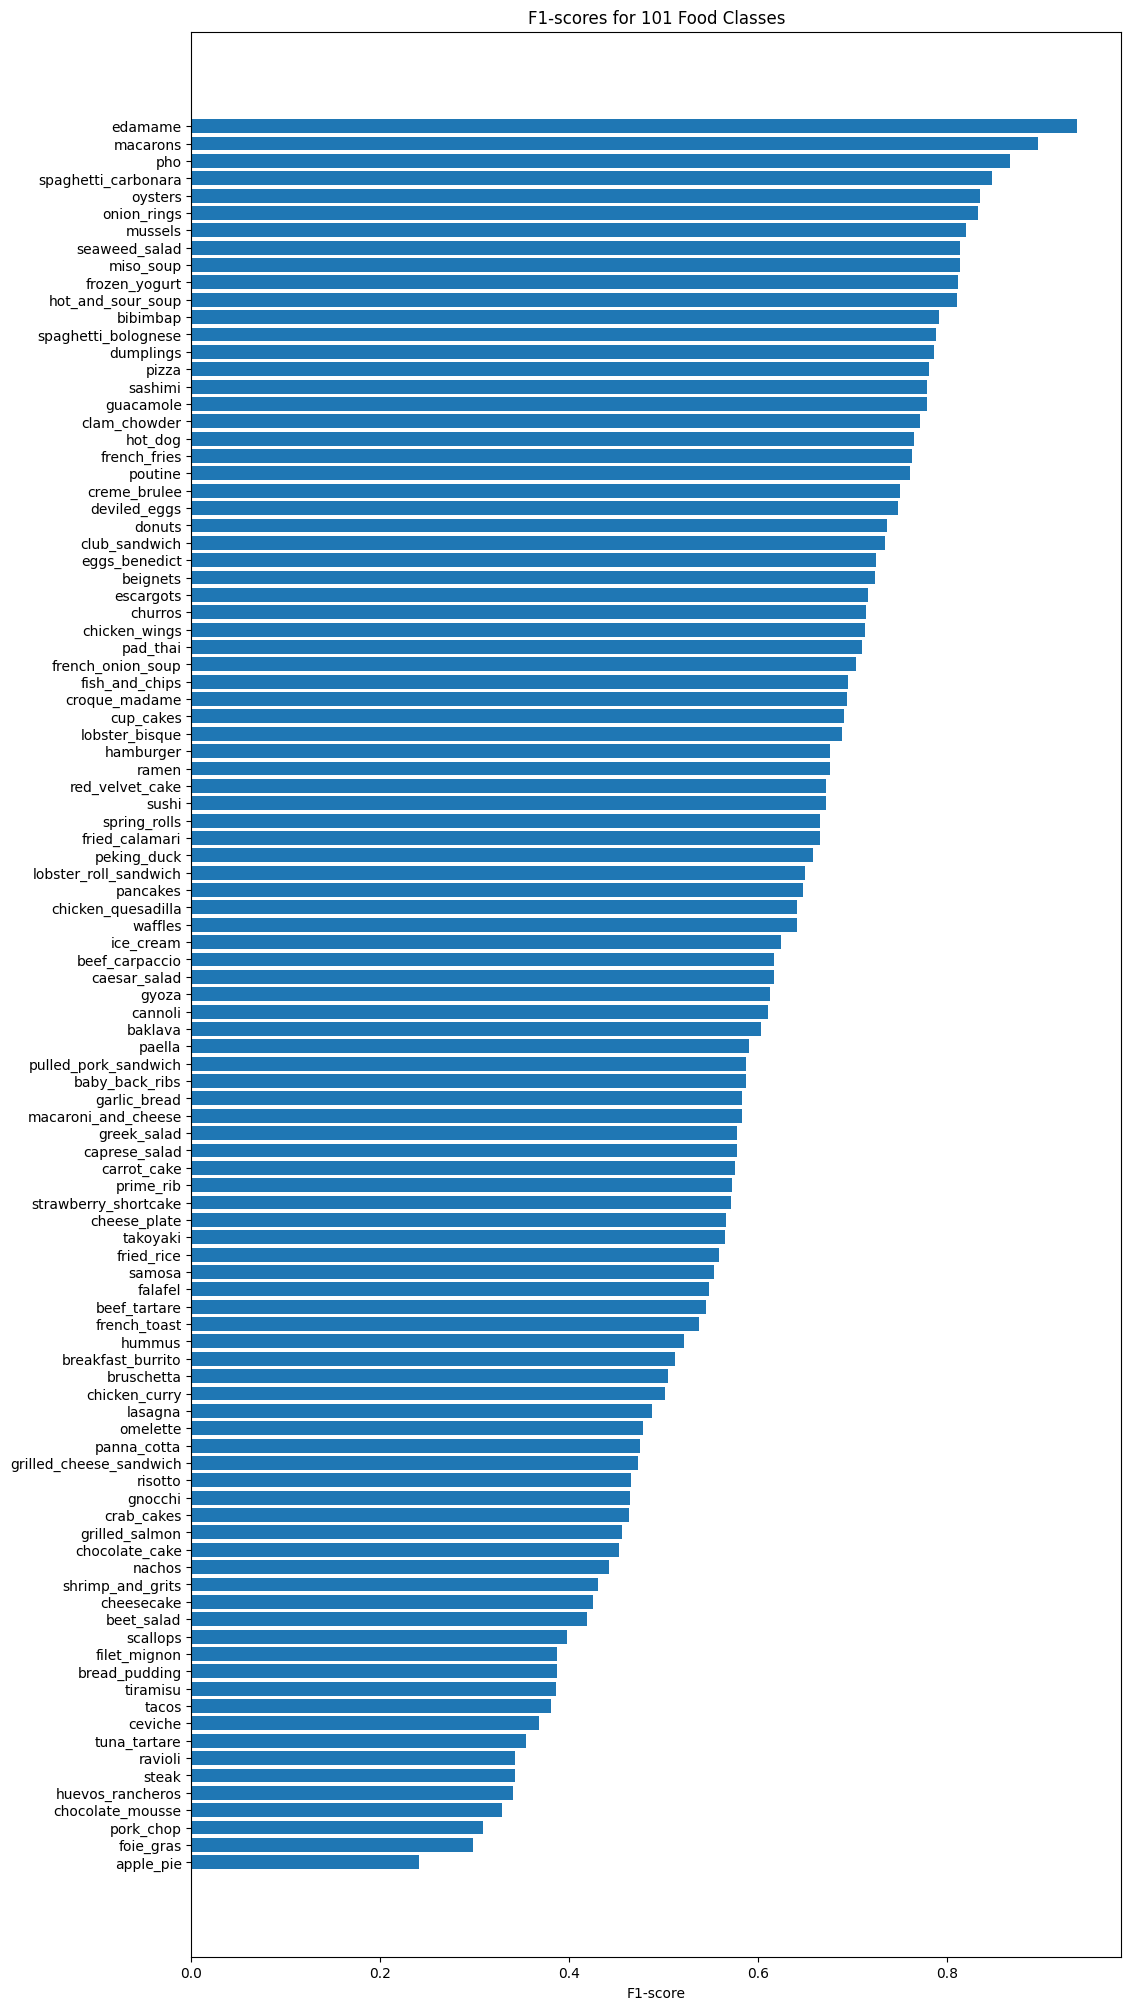

In [88]:
fig, ax = plt.subplots(figsize= (12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])
ax.set_xlabel('F1-score')
ax.set_title('F1-scores for 101 Food Classes')
ax.invert_yaxis()

# Challenge: Add values of each bar

## Visualizing predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset

We need to create a function which loads and preprocess the images

* Read in a target image filepath
* Turn the image into a tensor
* Resize the image tensor
* Scale the image if necessary

In [95]:
# Creaete a function to load and prepare iamges
def load_and_prep_image(filename, img_shape= 224, scale= True):
  '''
  Reads in an image from filenam, turns it into a tensor and reshape into
  specified shape (img_shape, img_shape, colou_channels= 3)

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (boo): scale pixel values from 0-255 to 0-1

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  '''

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels= 3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale
  if scale:
    # rescale the image
    return img/255.
  else:
    return img

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions

Specifically:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image along with the model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 35ms/step
baklava
1/1 [==============================] - 0s 41ms/step
beef_carpaccio
1/1 [==============================] - 0s 37ms/step
steak


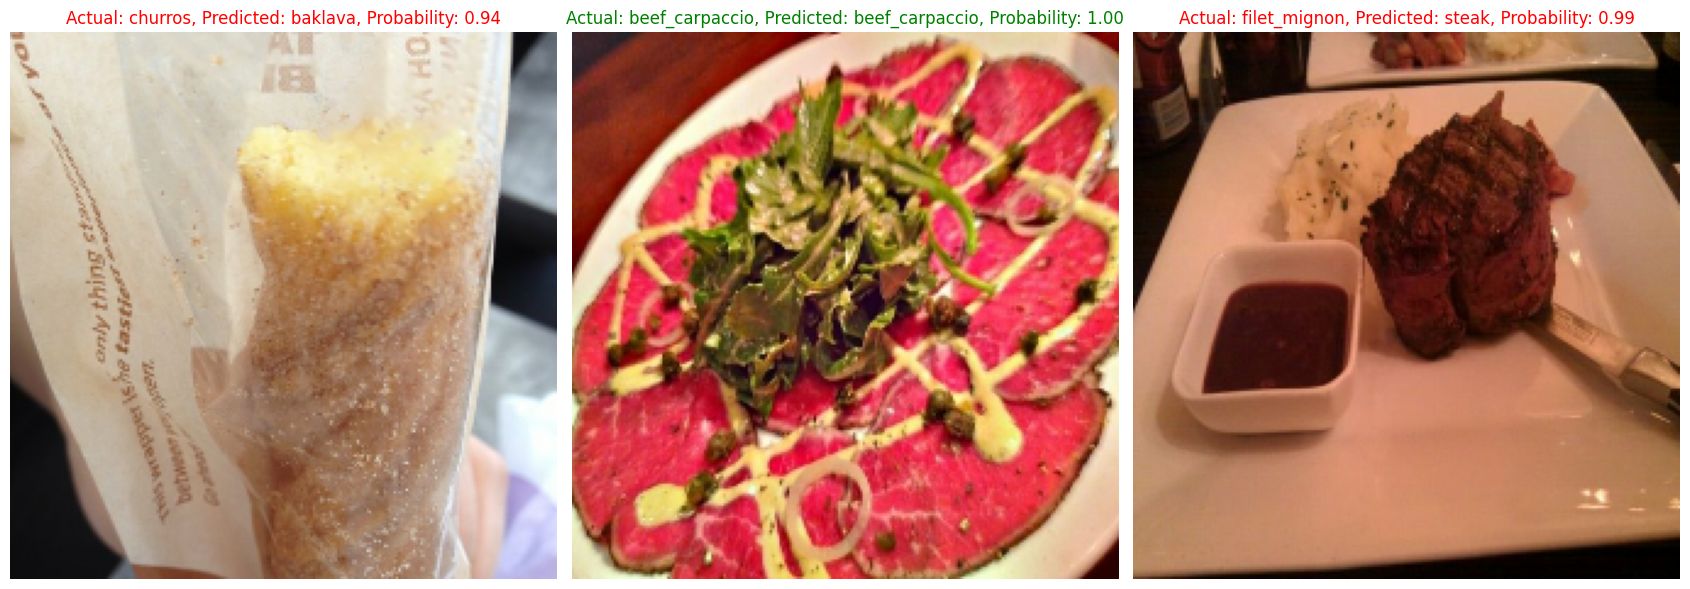

In [104]:
# Make predictions on a series of random images
import os
import random

plt.figure(figsize= (17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(TEST_DIR + "/" + class_name))
  filepath = TEST_DIR + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale= False)
  pred_prob = model.predict(tf.expand_dims(img, axis= 0))
  pred_class = class_names[pred_prob.argmax()]
  print(pred_class)

  # Plot the image
  plt.subplot(1, 3, i + 1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    # if predicted class matches our true class
    color = 'g'
  else:
    color = 'r'

  plt.title(f"Actual: {class_name}, Predicted: {pred_class}, Probability: {pred_prob.max():.2f}", c= color)
  plt.axis(False)
  plt.tight_layout()